In [1]:
!pip install torcheval

  Obtaining dependency information for torcheval from https://files.pythonhosted.org/packages/e4/de/e7abc784b00de9d05999657d29187f1f7a3406ed10ecaf164de06482608f/torcheval-0.0.7-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import cv2
import os

from tqdm import tqdm
from torcheval.metrics import MulticlassAccuracy
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [3]:
BATCH_SIZE = 256
EPOCHS = 100
LR = 1e-3

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
total_size = len(testset)
val_limit = int(0.8 * total_size)
test_limit = total_size - val_limit

val, test = torch.utils.data.random_split(testset, [val_limit, test_limit])

test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

val_loader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

num_classes = len(classes)

100%|██████████| 170498071/170498071 [00:02<00:00, 73489326.49it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
X, y = next(train_loader._get_iterator())

print(X.shape, y.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


In [6]:
class EarlyStopper:
    def __init__(self, patience=20, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def __call__(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [7]:
class MLPBlock(torch.nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int, dropout: float = 0.2):
        super(MLPBlock, self).__init__()
        self.block = torch.nn.Sequential(
            torch.nn.Linear(in_channels, hidden_channels),
            torch.nn.GELU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(hidden_channels, in_channels),
            torch.nn.Dropout(dropout),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x)


class MixerBlock(torch.nn.Module):
    def __init__(self, num_patches: int, dim: int, token_dim: int, channel_dim: int, dropout: float = 0.2):
        super(MixerBlock, self).__init__()
        self.token_mixing = MLPBlock(num_patches, token_dim, dropout)
        self.channels_mixing = MLPBlock(dim, channel_dim, dropout)
        self.pre_norm = torch.nn.LayerNorm(dim)
        self.post_norm = torch.nn.LayerNorm(dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x.clone()
        h = self.pre_norm(x)
        h = h.transpose(-1, -2)
        h = self.token_mixing(h)
        h = h.transpose(-1, -2)

        h = h + residual
        residual = h.clone()
        h = self.post_norm(h)
        h = self.channels_mixing(h)

        h = h + residual

        return h


class PatchEmbedding(torch.nn.Module):
    def __init__(self, in_channels: int, hidden_dim: int, width: int, patch_size: int):
        super().__init__()
        self.width = width
        self.patch_size = patch_size
        self.per_patch_fc = torch.nn.Conv2d(in_channels, hidden_dim, (patch_size, patch_size), patch_size)

    def forward(self, x: torch.Tensor):
        patches = self.per_patch_fc(x)
        B, C, W, H = patches.shape
        return patches.reshape(B, W * H, C)

In [8]:
class MLPMixer(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        image_size: tuple[int, int],
        patch_size: int,
        hidden_dim: int,
        num_mixers: int,
        num_classes: int,
        token_dim: int,
        channels_dim: int,
        dropout: float = 0.2,
    ) -> None:
        super(MLPMixer, self).__init__()
        W, H = image_size
        num_patches = (W * H) // (patch_size**2)
        self.patch_embedding = PatchEmbedding(in_channels, hidden_dim, W, patch_size)
        self.mixers = torch.nn.Sequential(
            *[MixerBlock(num_patches, hidden_dim, token_dim, channels_dim, dropout) for _ in range(num_mixers)]
        )
        self.g_avg_pooling = torch.nn.LayerNorm(hidden_dim)
        self.dropout = torch.nn.Dropout(dropout)
        self.fc = torch.nn.Linear(hidden_dim, num_classes)

    def forward(self, x: torch.Tensor):
        h = self.patch_embedding(x)
        h = self.mixers(h)
        h = self.g_avg_pooling(h)
        h = h.mean(dim = 1)
        h = self.dropout(h)
        h = self.fc(h)
        return F.softmax(h, dim=1)

In [9]:
model = MLPMixer(3, (32, 32), 4, 512, 8, num_classes, token_dim=256, channels_dim=2048, dropout=0.2)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
model = model.to(device)

In [12]:
num_params = sum(layer.numel() for layer in model.parameters())
print(f"{num_params:,}")

17,110,026


In [13]:
optimizer = torch.optim.Adam(model.parameters(), LR)
criterion = torch.nn.CrossEntropyLoss()
early_stopping = EarlyStopper(patience=20)

In [14]:
history = {
    "epoch" : [],
    "loss" : [], 
    "val_loss" : [],
    "acc" : [], 
    "val_acc" : []
}

for epoch in range(1, EPOCHS + 1):
    epoch_pbar = tqdm(range(0, len(train_loader)), desc=f"Epoch {epoch}/{EPOCHS}")
    epoch_train_loss = 0
    epoch_val_loss = 0
    train_acc = MulticlassAccuracy()
    val_acc = MulticlassAccuracy()
    
    for sample in train_loader:
        images, actual = sample
        images = images.to(device)
        actual = actual.to(device)
        
        pred = model(images.float())
        optimizer.zero_grad()
        _, pred_labels = torch.max(pred, dim=1)
        train_acc.update(actual, pred_labels)
        loss = criterion(pred, actual)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        epoch_pbar.update(1)
    epoch_train_loss /= len(train_loader)

    with torch.no_grad():
        for sample in val_loader:
            images, actual = sample
            images = images.to(device)
            actual = actual.to(device)
            pred = model(images.float())
            _, pred_labels = torch.max(pred, dim=1)
            val_acc.update(actual, pred_labels)
            loss = criterion(pred, actual)
            epoch_val_loss += loss.item()
        epoch_val_loss /= len(val_loader)
    
    history["epoch"].append(epoch)
    history["val_loss"].append(epoch_val_loss)
    history["loss"].append(epoch_train_loss)
    history["val_acc"].append(val_acc.compute().item())
    history["acc"].append(train_acc.compute().item())
    
    epoch_pbar.set_postfix({
        "loss" : f"{history['loss'][-1]:.4f}",
        "val_loss" : f"{history['val_loss'][-1]:.4f}",
        "acc" : f"{history['acc'][-1]:.4f}",
        "val_acc" : f"{history['val_acc'][-1]:.4f}",
    })
    
    if early_stopping(epoch_val_loss):
        print(f"The model stop at {epoch}")
        break
    
    epoch_pbar.close()

Epoch 89/100: 100%|██████████| 196/196 [01:12<00:00,  3.60it/s, loss=1.5350, val_loss=1.8277, acc=0.9262, val_acc=0.6326]

The model stop at 89


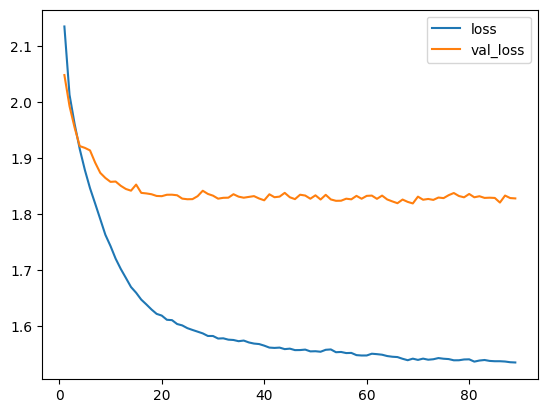

In [15]:
history_df = pd.DataFrame(history)

plt.plot(history_df["epoch"], history_df["loss"])
plt.plot(history_df["epoch"], history_df["val_loss"])
plt.legend(["loss", "val_loss"])

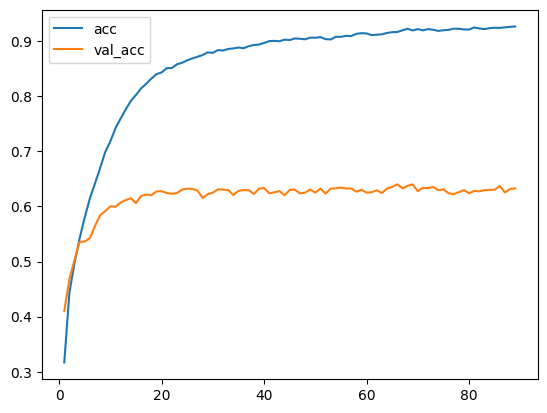

In [16]:
plt.plot(history_df["epoch"], history_df["acc"])
plt.plot(history_df["epoch"], history_df["val_acc"])
plt.legend(["acc", "val_acc"])

In [17]:
acc = MulticlassAccuracy()

for sample in test_loader:
    images, actual = sample
    images = images.to(device)
    actual = actual.to(device)
    pred = model(images.float())
    _, pred_labels = torch.max(pred, dim=1)
    acc.update(actual, pred_labels)
    
print(f"Accuracy: {acc.compute().item():.4f}")

Accuracy: 0.6340
